# Import Libraries

In [8]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.__version__)
if device == "cuda": print(torch.cuda.get_device_name()) 

cuda
2.0.0+cu117


# *Data Prep*

Training and Testing data is prepared from the solution file

In [9]:
x_1 = np.linspace(-1,1,256)  # 256 points between -1 and 1 [256x1]
x_2 = np.linspace(1,-1,256)  # 256 points between 1 and -1 [256x1]

X, Y = np.meshgrid(x_1,x_2) 


# Test Data

We prepare the test data to compare against the solution produced by the PINN.

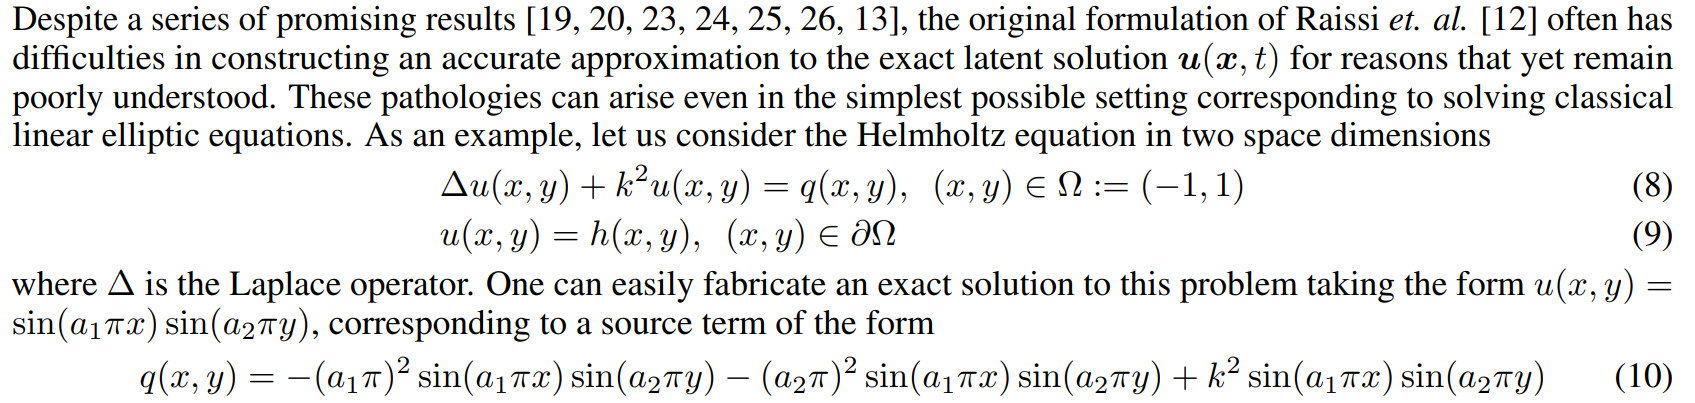

In [10]:
X_u_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None]))#(65536, 2)

# Domain bounds
lb = np.array([-1, -1]) #lower bound
ub = np.array([1, 1])  #upper bound

a_1 = 1
a_2 = 1

k = 10#波数（单频）

usol = np.sin(a_1 * np.pi * X) * np.sin(a_2 * np.pi * Y) #solution chosen for convinience  

u_true = usol.flatten('F')[:,None]  #所设空间点的真解

# Training Data

In [11]:
def trainingdata(N_u,N_f):
    #N_u：边界采样点数
    #N_f：PDE域采样点数（可能采到边界）
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None])) #左边界x=-1，[:,None]用于将(n,)向量拓展为矩阵形式的向量(n,1)
    leftedge_u = usol[:,0][:,None]-usol[:,0][:,None]#边界全为0
    
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,-1][:,None])) #右边界x=1
    rightedge_u = usol[:,-1][:,None]-usol[:,-1][:,None]
    
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None])) #上边界y=1
    topedge_u = usol[0,:][:,None]-usol[0,:][:,None]
    
    bottomedge_x = np.hstack((X[-1,:][:,None], Y[-1,:][:,None]))#下边界y=-1
    bottomedge_u = usol[-1,:][:,None]-usol[-1,:][:,None]
    
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  
     
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    
    X_u_train = all_X_u_train[idx[0:N_u], :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx[0:N_u],:]      #choose corresponding u
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f, X_u_train)) # append training points to collocation points ：包括边界采样点和PDE域采样点
    
    return X_f_train, X_u_train, u_train # X_u_train, u_train：边界采样点和边界物理值，X_f_train：边界采样点和PDE域采样点，用于训练，无对应物理值


# Physics Informed Neural Network

In [12]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        '''
        Alternatively:
        
        *all layers are callable 
    
        Simple linear Layers
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        
        '''
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            

    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input ：对输入进行归一化处理
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
                        
        '''     
        Alternatively:
        
        a = self.activation(self.fc1(a))
        a = self.activation(self.fc2(a))
        a = self.activation(self.fc3(a))
        a = self.fc4(a)
        
        '''
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)#最后一层没有激活函数
        
        return a
                        
    def loss_BC(self,x,y):
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u
    
    def loss_PDE(self, x_to_train_f):
                
        x_1_f = torch.tensor(x_to_train_f[:,0:1], requires_grad=True).float().to(device) #x 
        x_2_f =torch.tensor(x_to_train_f[:,1:2], requires_grad=True).float().to(device)  #y

        u_pred_train = self.forward(torch.cat([x_1_f, x_2_f ], dim=1))

        u_x = torch.autograd.grad(
            u_pred_train, x_1_f, 
            grad_outputs=torch.ones_like(u_pred_train),
            retain_graph=True,
            create_graph=True
        )[0]
               
        u_xx = torch.autograd.grad(
            u_x, x_1_f, 
            grad_outputs=torch.ones_like(u_pred_train),
            retain_graph=True,
            create_graph=True
        )[0]
                                                            
        u_y = torch.autograd.grad(
            u_pred_train, x_2_f, 
            grad_outputs=torch.ones_like(u_pred_train),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_yy = torch.autograd.grad(
            u_y, x_2_f, 
            grad_outputs=torch.ones_like(u_pred_train),
            retain_graph=True,
            create_graph=True
        )[0]
             
        q = ( -(a_1*np.pi)**2 - (a_2*np.pi)**2 + k**2 ) * torch.sin(a_1*np.pi*x_1_f) * torch.sin(a_2*np.pi*x_2_f)
                        
        f = u_xx/(k**2) + u_yy/(k**2) +  u_pred_train - q/(k**2) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)
        
        loss_val = loss_u + loss_f
        
        return loss_val,loss_u,loss_f
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss(X_u_train, u_train, X_f_train)
        
        error_vec, _ = PINN.test()
        
        print(loss,error_vec)
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        u_pred = self.forward(X_u_test_tensor)
        
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = np.reshape(u_pred.cpu().detach().numpy(),(256,256),order='F') 
        
        return error_vec, u_pred
    def test_train(self):
        u_train_pred = self.forward(X_f_train)
        u_train_pred = np.reshape(u_train_pred.cpu().detach().numpy(),(X_f_train.shape[0],X_f_train.shape[0]),order='F') 
        return u_train_pred

# *Solution Plot*

In [13]:
def solutionplot(u_pred,X_u_train,u_train):

    #Ground truth
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(x_1, x_2, usol, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Ground Truth $u(x_1,x_2)$', fontsize=15)

    # Prediction
    plt.subplot(1, 3, 2)
    plt.pcolor(x_1, x_2, u_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Predicted $\hat u(x_1,x_2)$', fontsize=15)

    # Error
    plt.subplot(1, 3, 3)
    plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title(r'Absolute error $|u(x_1,x_2)- \hat u(x_1,x_2)|$', fontsize=15)
    plt.tight_layout()

    plt.savefig('Helmholtz_non_stiff.png', dpi = 500, bbox_inches='tight')

# Main

In [14]:
N_u = 400 #Total number of data points for 'u'
N_f = 20000 #Total number of collocation points 

# Training data
X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f)

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
u_train = torch.from_numpy(u_train_np_array).float().to(device)
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

layers = np.array([2, 50,50,50,50,50, 1]) #3 hidden layers

PINN = Sequentialmodel(layers)
       
PINN.to(device)

'Neural Network Summary'

print(PINN)

params = list(PINN.parameters())

'''Optimization'''

# 'L-BFGS Optimizer'

# optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1, 
#                               max_iter = 1000, 
#                               max_eval = None, 
#                               tolerance_grad = 1e-06, 
#                               tolerance_change = 1e-09, 
#                               history_size = 100, 
#                               line_search_fn = 'strong_wolfe')


# start_time = time.time()

# optimizer.zero_grad()     # zeroes the gradient buffers of all parameters

# optimizer.step(PINN.closure)


'Adam Optimizer'

optimizer = optim.Adam(PINN.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

max_iter = 2000
start_time = time.time()

for i in range(max_iter):

    loss,loss_u,loss_f = PINN.loss(X_u_train, u_train, X_f_train)
           
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    
    loss.backward() #backprop

    optimizer.step()
    
    if i % (max_iter/50) == 0:

        error_vec, _ = PINN.test()
        
        print(loss.item(),loss_u.item(),loss_f.item(),error_vec.item())
        


    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))




Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-4): 4 x Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)
0.16248513758182526 0.004310143645852804 0.15817499160766602 1.0159660577774048


C:\Users\dsj\AppData\Local\Temp\ipykernel_21312\1398510960.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_1_f = torch.tensor(x_to_train_f[:,0:1], requires_grad=True).float().to(device) #x
C:\Users\dsj\AppData\Local\Temp\ipykernel_21312\1398510960.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_2_f =torch.tensor(x_to_train_f[:,1:2], requires_grad=True).float().to(device)  #y


0.15100091695785522 0.0007170707685872912 0.1502838432788849 0.9808880686759949
0.13600987195968628 0.01738971658051014 0.11862014979124069 0.8851672410964966
0.11848431080579758 0.020769843831658363 0.09771446883678436 0.8078046441078186
0.106663778424263 0.01798834092915058 0.08867543935775757 0.7671706676483154
0.09037411212921143 0.017026767134666443 0.07334734499454498 0.7083845138549805
0.08165796101093292 0.016017001122236252 0.06564096361398697 0.680107057094574
0.06331677734851837 0.01324564591050148 0.05007113516330719 0.6151211261749268
0.032133135944604874 0.00844262819737196 0.02369050867855549 0.47395050525665283
0.010702282190322876 0.002861565910279751 0.007840716280043125 0.2940584719181061
0.004055333789438009 0.0011982943397015333 0.002857039449736476 0.2311723232269287
0.0025511549320071936 0.0008010690216906369 0.0017500858521088958 0.17906183004379272
0.0018255577888339758 0.0006522663752548397 0.001173291471786797 0.1458696573972702
0.001709889736957848 0.0006056

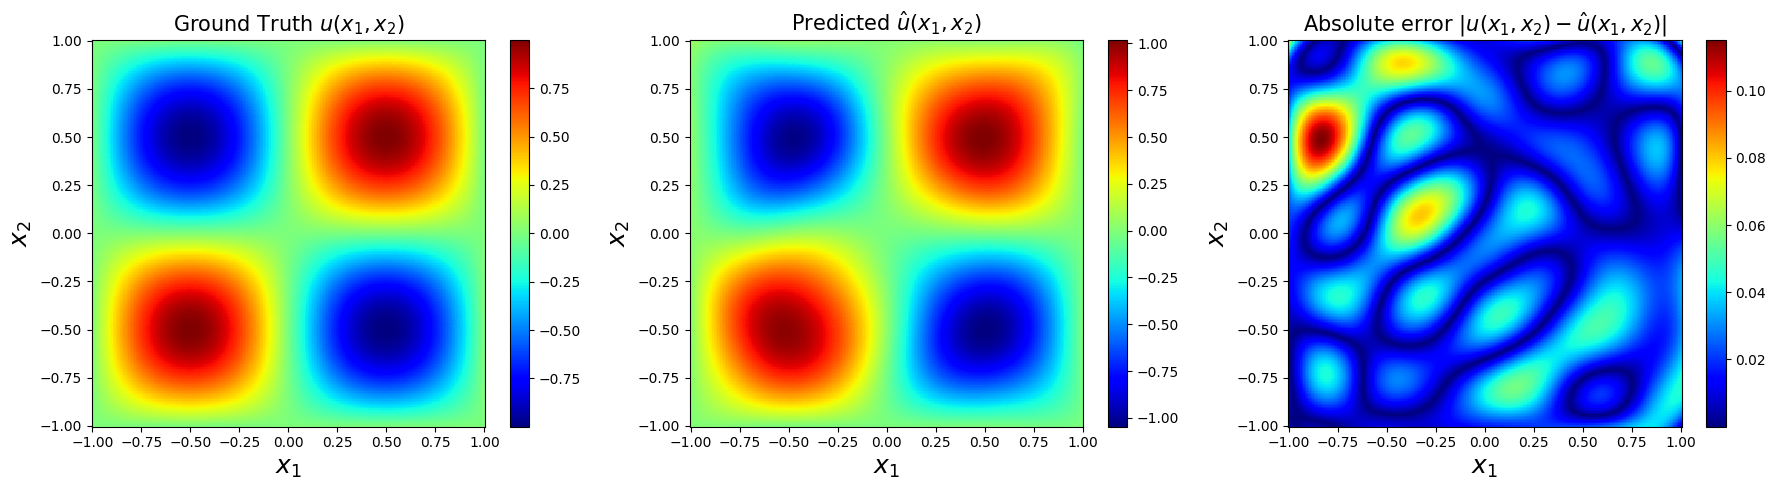

In [15]:
''' Solution Plot '''
error_vec, u_pred = PINN.test()
solutionplot(u_pred,X_u_train,u_train)